[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/108_cfd_mat/108_cfd_mat.ipynb)

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import matplotlib.pyplot as plt
from mesh import Mesh
import time
import numpy as np 
import math
import fluxes 
import temporal_schemes 
from bocos import DirichletBC, NeumannBC
import time 

def plot(mesh, p, t):
	fig = plt.figure(figsize=(10, 5))
	ax1 = fig.add_subplot(111, projection='3d')
	mesh.plot_field(p, ax1, f't = {t:.3f}')
	plt.show()

vel = lambda x, y: np.array([2.*y*(1-x**2), -2.*x*(1-y**2)])

def simulate(mesh, ALPHA, tf, CFL=1., ss='upwind', ts='euler'):
	t0 = time.time()
	p0 = np.zeros_like(mesh.c)
	bcl = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]])
	bcr = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]])
	bct = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]])
	bcbl = DirichletBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0], [1 + math.tanh(ALPHA*(2.*mesh.f[i].c.x+1)) for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0])
	bcbr = NeumannBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x > 0])
	bcs = [bcl, bcr, bcbl, bcbr]
	t = 0
	dt = CFL*min(2/mesh.Nx, 1/mesh.Ny) / max([np.linalg.norm(vel(f.c.x, f.c.y)) for f in mesh.f])
	p = p0.copy()
	R = np.zeros_like(p)
	it = 0
	t1 = time.time()
	t_setup = t1 - t0
	t0 = time.time()
	while t < tf:
		# update temporal
		if t + dt > tf:
			dt = tf - t
		t = t + dt
		it += 1
		F = getattr(fluxes, ss)(mesh, vel, p)
		# F = central(mesh, vel, p)
		for bc in bcs:
			F = bc.flux_conv(mesh, F, vel, p)
		p, R = getattr(temporal_schemes, ts)(F, mesh, p, dt, R)
		# p, R = ab2(F, mesh, p, dt, R)
	t1 = time.time()
	t_sim = t1 - t0
	return p, it, t_setup, t_sim

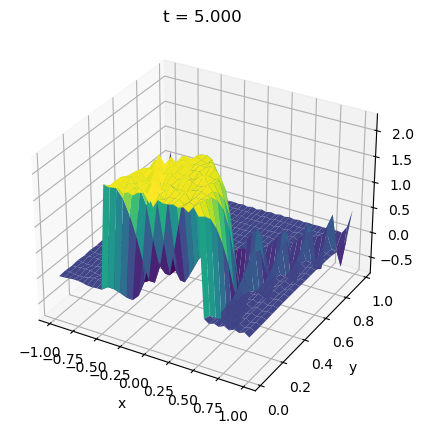

In [12]:
Nx, Ny = 40, 20
mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
ALPHA, tf = 1e8, 5
p, _, _, _ = simulate(mesh, ALPHA, tf, CFL=0.5, ss='central', ts='ab2')
# p, _ = simulate(mesh, ALPHA, tf, ss="central", ts="ab2", CFL=0.5)
plot(mesh, p, tf)


In [13]:

schemes = [('upwind', 'euler', 0.5), ('upwind', 'ab2', 0.5), ('central', 'euler', 0.5), ('central', 'ab2', 0.5)]
Nxs, Nys = [20, 50], [10, 25]
ALPHA, tf = 1e8, 5

for scheme in schemes:
	ss, ts, CFL = scheme
	for Nx, Ny in zip(Nxs, Nys):
		mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
		p, it, t_setup, t_sim = simulate(mesh, ALPHA, tf, CFL, ss, ts)
		print(f'{ss}, {ts}: N = {Nx}x{Ny}, t_setup = {t_setup:.3f}s, t_sim = {t_sim:.3f} its = {it}, its/s = {it/(t_sim):.3f}')


upwind, euler: N = 20x10, t_setup = 0.003s, t_sim = 0.823 its = 200, its/s = 242.973
upwind, euler: N = 50x25, t_setup = 0.013s, t_sim = 12.786 its = 500, its/s = 39.105
upwind, ab2: N = 20x10, t_setup = 0.002s, t_sim = 0.834 its = 200, its/s = 239.674
upwind, ab2: N = 50x25, t_setup = 0.013s, t_sim = 13.106 its = 500, its/s = 38.150
central, euler: N = 20x10, t_setup = 0.002s, t_sim = 0.551 its = 200, its/s = 363.077
central, euler: N = 50x25, t_setup = 0.013s, t_sim = 8.522 its = 500, its/s = 58.674
central, ab2: N = 20x10, t_setup = 0.002s, t_sim = 0.565 its = 200, its/s = 354.079
central, ab2: N = 50x25, t_setup = 0.013s, t_sim = 8.632 its = 500, its/s = 57.922


In [14]:
import numpy as np
from bocos2 import DirichletBC2, NeumannBC2
import temporal_schemes2
import fluxes2

def simulate2(mesh, ALPHA, tf, CFL=1., ss='Upwind', ts='Euler'):
	t0 = time.time()
	p0 = np.zeros_like(mesh.c)
	bcl = DirichletBC2([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]])
	bcr = DirichletBC2([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]])
	bct = DirichletBC2([i for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]])
	bcbl = DirichletBC2([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0], [1 + math.tanh(ALPHA*(2.*mesh.f[i].c.x+1)) for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0])
	bcbr = NeumannBC2([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x > 0])
	bcs = [bcl, bcr, bcbl, bcbr]
	for bc in bcs:
		bc.setup(mesh, vel)
	t = 0
	dt = CFL*min(2/mesh.Nx, 1/mesh.Ny) / max([np.linalg.norm(vel(f.c.x, f.c.y)) for f in mesh.f])
	p = p0.copy()
	R = np.zeros_like(p)
	it = 0
	ts = getattr(temporal_schemes2, ts)(mesh)
	ss = getattr(fluxes2, ss)(mesh, vel)
	t1 = time.time()
	t_setup = t1 - t0
	t0 = time.time()
	while t < tf:
		# update temporal
		if t + dt > tf:
			dt = tf - t
		t = t + dt
		it += 1
		# print(it, t, dt)
		F = ss(p)
		for bc in bcs:
			F += bc.flux_conv(p)
		p, R = ts(F, p, dt)
	t1 = time.time()
	t_sim = t1 - t0
	return p, it, t_setup, t_sim

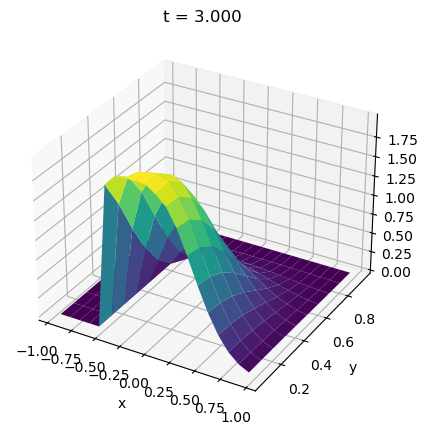

In [15]:
Nx, Ny = 20, 10
mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
ALPHA, tf = 1e8, 3
p, it, _, _ = simulate2(mesh, ALPHA, tf, CFL=0.5, ss='Upwind', ts='Euler')
# p, _ = simulate(mesh, ALPHA, tf, ss="central", ts="ab2", CFL=0.5)
plot(mesh, p, tf)

In [17]:
schemes = [('Upwind', 'Euler', 0.5)]
Nxs, Nys = [20, 50], [10, 25]
ALPHA, tf = 1e8, 5

for scheme in schemes:
	ss, ts, CFL = scheme
	for Nx, Ny in zip(Nxs, Nys):
		mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
		p, it, t_setup, t_sim = simulate2(mesh, ALPHA, tf, CFL, ss, ts)
		print(f'{ss}, {ts}: N = {Nx}x{Ny}, t_setup = {t_setup:.3f}s, t_sim = {t_sim:.3f}, its = {it}, its/s = {it/(t_sim):.3f}')

Upwind, Euler: N = 20x10, t_setup = 0.007s, t_sim = 3.874 its = 200, its/s = 51.624
